# NDMI Calculation CDMX

NDMI database has until 2023. 
This notebook runs and saves locally NDMI in CDMX for ene-mar 2024.

## Import libraries

In [1]:
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
import planetary_computer as pc
import geopandas as gpd
import h3
import pandas as pd

import rasterio
from rasterio import windows
from rasterio import features
from rasterio import warp
import rasterio.mask
from rasterio.enums import Resampling
from rasterio.merge import merge

import numpy as np
from PIL import Image

import matplotlib.pyplot as plt

from shapely.geometry import Point

from tqdm import tqdm

import os
import sys
module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/jovyan/accesibilidad-urbana/aup/data.py:25: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(


## Config notebook

In [6]:
# Set raster spectral bands and analysis equation
band_name_dict = {'swir16':[True], #If GSD(resolution) of band is different, set True.
                  'nir':[True], #If GSD(resolution) of band is different, set True.
                  'eq':["(nir-swir16)/(nir+swir16)"]}

# Set analysis name
index_analysis = 'ndmi'

# Set directory to save analysed rasters
tmp_dir = f'../../../data/processed/tmp_{index_analysis}/'

# Set desired hex resolution
res = [8,11]

# Set frequency of search for rasters (MS = Month Start)
freq = 'MS'

# Set start and end date for search (Sentinel-2 2A has images since mids 2015)
start_date = '2024-01-01'
end_date = '2024-03-16'

# Save?
local_save = True # Save to Visual Studio in tmp_dir/local_save
save = False # Save to db

# Del rasters after processing.
del_data = False # True

# city can be substituted by "place". (presa_laboca / presa_cerroprieto / presa_elcuchillo)
city = 'CDMX'

#Set filter if necessary. Defaults to "{}". Example: No images with cloud cover avobe 10%: {"eo:cloud_cover": {"lt": 10}}
query = {"eo:cloud_cover": {"lt": 10}}

# Set satellite. Defaults to "sentinel-2-l2a"
satellite = 'sentinel-2-l2a'

## Load data

### Load data - Area of interest

<Axes: >

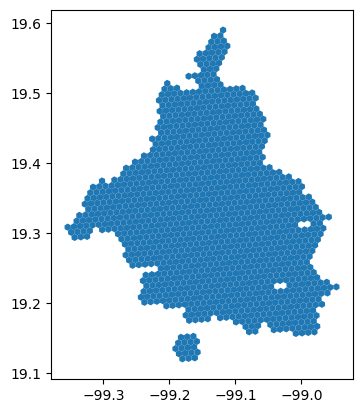

In [12]:
### Create city area of interest with biggest hexs
big_res = min(res)
schema_hex = 'hexgrid'
table_hex = f'hexgrid_{big_res}_city_2020'

# Download hexagons with type=urban
type = 'urban'
query = f"SELECT hex_id_{big_res},geometry FROM {schema_hex}.{table_hex} WHERE \"city\" = '{city}\' AND \"type\" = '{type}\'"
hex_urban = aup.gdf_from_query(query, geometry_col='geometry')

# Download hexagons with type=rural within 500m buffer
poly = hex_urban.to_crs("EPSG:6372").buffer(500).reset_index()
poly = poly.to_crs("EPSG:4326")
poly_wkt = poly.dissolve().geometry.to_wkt()[0]
type = 'rural'
query = f"SELECT hex_id_{big_res},geometry FROM {schema_hex}.{table_hex} WHERE \"city\" = '{city}\' AND \"type\" = '{type}\' AND (ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\'))"
hex_rural = aup.gdf_from_query(query, geometry_col='geometry')

# Concatenate urban and rural hex
hex_city = pd.concat([hex_urban, hex_rural])
hex_city.plot()

### Load data - Download and process rasters

In [15]:
#download_raster_from_pc(gdf, index_analysis, city, freq, start_date, end_date, tmp_dir, band_name_dict, query={}, satellite="sentinel-2-l2a"):
df_len = aup.download_raster_from_pc(hex_city, index_analysis, city, freq, 
                                     start_date, end_date, tmp_dir, band_name_dict, query = query, satellite = satellite)

ValueError: Cannot set a DataFrame with multiple columns to the single column month

## Create hexgrid

In [6]:
res = [11]

In [7]:
poly_gdf = gpd.GeoDataFrame(polygon)
hex_gdf = gpd.GeoDataFrame()

if len(res)>1: #If there is more than one resolution
    for r in res:
        hex_tmp = aup.create_hexgrid(poly_gdf, r)
        hex_tmp.rename(columns={f'hex_id_{r}':'hex_id'}, inplace=True)
        hex_tmp['res'] = r
        hex_gdf = pd.concat([hex_gdf, hex_tmp], ignore_index=True, axis=0)
        del hex_tmp

else: #If there is only one resolution
    hex_gdf = aup.create_hexgrid(poly_gdf, res[0])
    hex_gdf.rename(columns={f'hex_id_{res[0]}':'hex_id'}, inplace=True)
    hex_gdf['res'] = res[0]
    
#Show
print(hex_gdf.shape)
hex_gdf.head(2)

(20807, 3)


,hex_id,geometry,res
0,8b4986399626fff,"POLYGON ((-100.05293 19.46169, -100.05275 19.4...",11
1,8b498676d0a3fff,"POLYGON ((-99.99098 19.43744, -99.99080 19.437...",11


In [8]:
def raster_to_hex_save(hex_gdf_i, df_len, index_analysis, tmp_dir, city, r, save, i=0):
    hex_raster_analysis, df_raster_analysis = aup.raster_to_hex_analysis(hex_gdf_i, df_len, index_analysis,
                                                                tmp_dir, city, r)

    if local_save:
        hex_raster_analysis.to_file(tmp_dir+'local_save/'+f'{city}_{index_analysis}_HexRes{r}_v{i}.geojson')
        df_raster_analysis.to_csv(tmp_dir+'local_save/'+f'{city}_{index_analysis}_HexRes{r}_v{i}.csv')

    if save:
        # GDF upload
        aup.gdf_to_db_slow(hex_raster_analysis, f'{index_analysis}_analysis_hex','raster_analysis', if_exists='append')
        
        # DF upload
        limit_len = 5000000
        if len(df_raster_analysis)>limit_len:
            c_upload = len(df_raster_analysis)/limit_len
            for k in range(int(c_upload)+1):
                print(f"Starting range k = {k} of {int(c_upload)}.")
                df_inter_upload = df_raster_analysis.iloc[int(limit_len*k):int(limit_len*(1+k))].copy()
                aup.df_to_db_slow(df_inter_upload,f'{index_analysis}_complete_dataset_hex','raster_analysis', if_exists='append')
        else:
            aup.df_to_db_slow(df_raster_analysis,f'{index_analysis}_complete_dataset_hex','raster_analysis', if_exists='append')

In [9]:
for r in list(hex_gdf.res.unique()):

    processing_chunk = 150000

    # filters hexagons at specified resolution
    hex_gdf_res = hex_gdf.loc[hex_gdf.res==r].copy()
    hex_gdf_res = hex_gdf_res.reset_index(drop=True)
    
    if len(hex_gdf_res)>processing_chunk:
        c_processing = len(hex_gdf_res)/processing_chunk
        
        for i in range(int(c_processing)):
            hex_gdf_i = hex_gdf_res.iloc[int(processing_chunk*i):int(processing_chunk*(1+i))].copy()
            raster_to_hex_save(hex_gdf_i, df_len, index_analysis, tmp_dir, city, r, save, i)
    else:
        hex_gdf_i = hex_gdf_res.copy()
        raster_to_hex_save(hex_gdf_i, df_len, index_analysis, tmp_dir, city, r, save)

 14%|███████████████████▌                                                                                                                     | 1/7 [01:03<06:18, 63.04s/it]

 43%|██████████████████████████████████████████████████████████▋                                                                              | 3/7 [03:29<04:43, 70.97s/it]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 5/7 [06:13<02:35, 78.00s/it]

  0%|                                                                                                                                                 | 0/2 [00:41<?, ?it/s]
